### Import des libraries

In [1]:
import gdown
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

### Téléchargement du dataset

In [2]:
#Téléchargement du dataset
url = 'https://drive.google.com/uc?export=download&id=1baFagxAZlZ-EM4iraO9WVXoNqOxayq5g'
output = 'dataset.zip'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

#Dézippage du dataset

def unzip(zip_file, dest_dir):
    import zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

unzip('dataset.zip', './')

Downloading...
From: https://drive.google.com/uc?export=download&id=1baFagxAZlZ-EM4iraO9WVXoNqOxayq5g
To: c:\Users\Erwan\Documents\Programmation\Python\Machine learning\Automatants\Automathon01 - chiffres\dataset.zip
100%|██████████| 5.93M/5.93M [00:00<00:00, 19.8MB/s]


### Load le dataset

In [3]:
X_train = np.load('customX_train.npy') # shape (16384, 28, 28, 3)
Y_train = np.load('customY_train.npy')
X_test = np.load('customX_test.npy')

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(16384, 28, 28, 3)
(16384,)
(4096, 28, 28, 3)


### Encodage one hot

In [4]:
# convert Y_train to one hot
Y_train_onehot = Y_train
#Y_train_onehot = np.zeros((len(Y_train), 10 ))
#Y_train_onehot[np.arange(len(Y_train)), Y_train.astype(int)] = 1

### Afficher les données

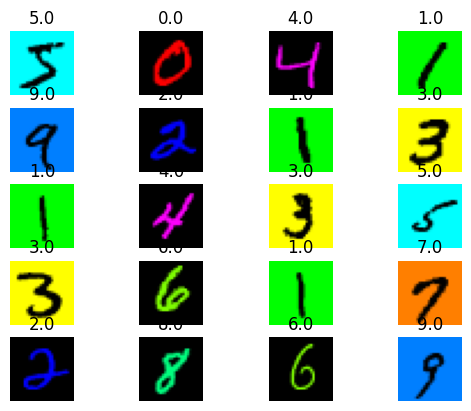

In [5]:
for i in range(20):
	plt.subplot(5, 4, i + 1)
	plt.imshow(X_train[i])
	plt.title(Y_train[i])
	plt.axis('off')

### Préparation de l'entraînement. On va transformer les données en des batches de données.

(16384, 28, 28) (4096, 28, 28)


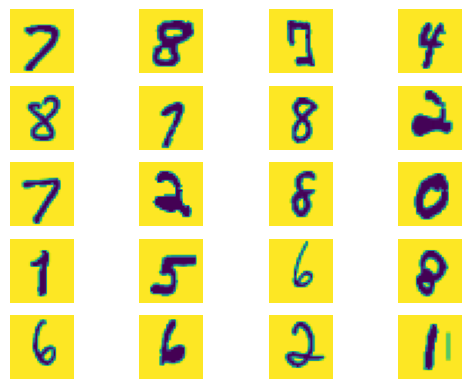

In [6]:
#On met les img en noir et blanc
#On essaie de mettre les mêmes fonds


#Faire la moyenne sur la 3ème dimenison : X_TRAIN
X_train_dim = []

for image in X_train:
    # Calculer la moyenne sur la troisième dimension (canal RVB)
    image_moyenne_train = np.mean(image, axis=2).astype(np.uint8)
    X_train_dim.append(image_moyenne_train)

#Faire la moyenne sur la 3ème dimenison : X_TEST
X_test_dim = []
for image in X_test:
    # Calculer la moyenne sur la troisième dimension (canal RVB)
    image_moyenne_test = np.mean(image, axis=2).astype(np.uint8)
    X_test_dim.append(image_moyenne_test)

X_train = np.array(X_train_dim)
X_test = np.array(X_test_dim)
print(X_train.shape, X_test.shape)

#On met tout sur le même fond
L = []
#TRAIN
for i in range(len(X_train)):
    #L.append(image[0,0])
    pixel_train = X_train[i][0][0]
    if pixel_train == 0:
      X_train[i] = 255 - X_train[i]
#TEST
for i in range(len(X_test)):
    #L.append(image[0,0])
    pixel_test = X_test[i][0][0]
    if pixel_test == 0:
      X_test[i] = 255 - X_test[i]

#AFFICHAGE TEST
for i in range(20):
	plt.subplot(5, 4, i + 1)
	plt.imshow(X_test[100+i])
	plt.axis('off')

In [7]:
BATCH_SIZE = 64
EPOCHS = 10

# reshape to batch of BATCH_SIZE
X_train = X_train.reshape(len(X_train)//BATCH_SIZE, BATCH_SIZE, 28, 28)
Y_train_onehot = Y_train_onehot.reshape(len(Y_train_onehot)//BATCH_SIZE, BATCH_SIZE) #plus des onehot, j'ai juste gardé le nom

print(X_train.shape)
print(X_test.shape)
print(Y_train_onehot.shape)

(256, 64, 28, 28)
(4096, 28, 28)
(256, 64)


### Convertir les vecteurs numpy en tenseur

In [8]:
X_train = torch.from_numpy(X_train).float()
X_train = torch.unsqueeze(X_train, axis=2) #ajoute une dimension pour être de la forme (64, 1, 28, 28)

Y_train_onehot = torch.from_numpy(Y_train_onehot).long() #long c'est des entiers

X_test = torch.from_numpy(X_test).float()
X_test = torch.unsqueeze(X_test, axis=1)
print(X_test.shape)

torch.Size([4096, 1, 28, 28])


In [9]:
X_train.shape

torch.Size([256, 64, 1, 28, 28])

### Définir le modèle.

In [10]:
model = nn.Sequential(
    #dim : (3, 28, 28)

    nn.Conv2d(1, 64, 3),
    nn.ReLU(),
    #dim : (64, 26, 26)
    nn.MaxPool2d(2),
    #dim : (64, 13, 13)

    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    #dim : (128, 11, 11)
    nn.MaxPool2d(2),
    #dim : (128, 5, 5)

    nn.Flatten(),

    nn.Linear(128 * 5 * 5, 32),
    nn.ReLU(),
    nn.Linear(32, 10))
    #nn.Softmax())

### Définir la loss et l'optimizer.

In [11]:
#loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Boucle d'entraînement.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
#sur le GPU
model.to(device)
total = 0
print(X_train.shape)
# training loop
for epoch in range(20):
	for i, batch in enumerate(X_train):
		# forward pass
		batch_GPU = batch.to(device)

		Y_train_onehot_GPU = Y_train_onehot[i].to(device)


		y_pred = model(batch_GPU)
		loss = loss_fn(y_pred, Y_train_onehot_GPU)

		# backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		predicted = torch.argmax(y_pred, dim=1)
		diff = predicted - Y_train_onehot_GPU

		accuracy = len(diff[diff==0]) / len(diff)
		total += Y_train_onehot_GPU.size(0)

		if i % 200 == 0:
			#print(y_pred.shape)
			print(f'Epoch {epoch} Loss {loss.item()} Accuracy {accuracy}')

torch.Size([256, 64, 1, 28, 28])
Epoch 0 Loss 8.828768730163574 Accuracy 0.078125


Epoch 0 Loss 0.5421154499053955 Accuracy 0.828125
Epoch 1 Loss 0.3963228166103363 Accuracy 0.921875
Epoch 1 Loss 0.3984829783439636 Accuracy 0.921875


### Evaluer le modèle sur les données de test.

In [14]:
# testing loop
with torch.no_grad():

	X_test_GPU = X_test.to(device)
	correct = 0
	total = 0
	y_pred = model(X_test_GPU)
	_, predicted = torch.max(y_pred.data, 1)

print(predicted)
# save predictions to file as npy
# np.save('customY_pred.npy', predicted.cpu().numpy())

tensor([4, 7, 3,  ..., 2, 9, 5])


### Prédiction du modèle en image avec des éléments aléatoires de X_test

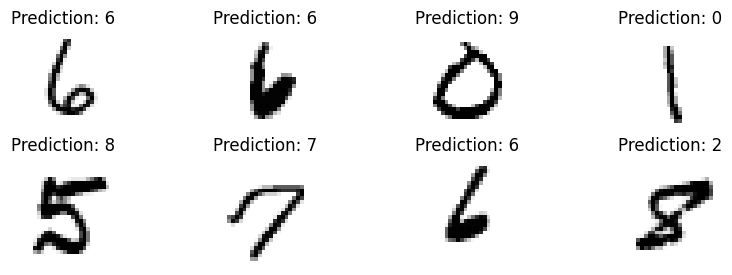

In [15]:
# Sélection aléatoire de 20 indices uniques dans X_test
import random
random_indices = random.sample(range(len(X_test)), 8)

# Prédictions pour les 20 chiffres sélectionnés
with torch.no_grad():
    X_random_test = X_test[random_indices].to(device)
    y_pred = model(X_random_test)
    _, predicted_labels = torch.max(y_pred, 1)

# Affichage des images et prédictions
plt.figure(figsize=(10, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[idx].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f"Prediction: {predicted_labels[i].item()}")
    plt.axis('off')
plt.show()

### Interaction avec le modèle

## Cette section n'est executable que dans un Google colab !
Modifiez `thickness`, `background_color`, `stroke_color` pour modifier l'épaisseur, la couleur du background, la couleur du chiffre.

Double click sur le dessin pour faire la prédiction.

In [16]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
from io import BytesIO
import base64


def draw_canvas():
	"""Create a canvas for user to draw a digit."""
	display(Javascript('''
        async function createCanvas() {
            const thickness = 20;
            const background_color = "rgb(255, 255, 255)";
            const stroke_color = "rgb(0, 0, 0)";

            const div = document.createElement('div');
            div.innerHTML = `<canvas id="canvas" width="560" height="560" style="border:1px solid; cursor:crosshair;"></canvas>`;
            document.body.appendChild(div);

            const canvas = div.querySelector('#canvas');
            const ctx = canvas.getContext('2d');
            ctx.lineWidth = thickness;
            ctx.fillStyle = background_color;
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            ctx.fillStyle = stroke_color;
            ctx.strokeStyle = stroke_color;

            let drawing = false;
            canvas.addEventListener('mousedown', () => { drawing = true; });
            canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
            canvas.addEventListener('mousemove', draw);

            function draw(event) {
                if (!drawing) return;
                ctx.lineWidth = thickness;
                ctx.lineCap = 'round';
                ctx.fillStyle = stroke_color

                ctx.lineTo(event.offsetX, event.offsetY);
                ctx.stroke();
                ctx.beginPath();
                ctx.moveTo(event.offsetX, event.offsetY);
            }

            await new Promise(resolve => canvas.addEventListener('dblclick', () => {
                const data = canvas.toDataURL('image/png');
                div.remove();
                resolve(data);
            }));
            return canvas.toDataURL('image/png');
        }
    '''))
	return eval_js("createCanvas()")


image_uri = draw_canvas()
image_uri = image_uri.split(",")[1]
image = Image.open(BytesIO(base64.b64decode(image_uri))).convert("RGB").resize((28, 28))
image = np.array(image, dtype=int)

import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

image = np.mean(image, axis=2).astype(np.uint8)
# prediction
#image = np.transpose(image, (0, 3, 1, 2))
image = torch.from_numpy(image).float()
image = torch.unsqueeze(image, axis=0)
image = torch.unsqueeze(image, axis=0) #car batch de taille 1

with torch.no_grad():
	y_pred = model(image.to(device))
	_, predicted = torch.max(y_pred.data, 1)
	print("Prédiction du modèle:", predicted.item())

ModuleNotFoundError: No module named 'google'

**Différentes améliorations du réseau:**

Réseaux normal

Réseau convolutif

Changement de Loss

Images en noires et blancs

Le fond des images toutes en blanche